In [23]:
#module for reading a mongodb collection into python lists
import pprint
from pymongo import MongoClient
from collections import Counter
import csv

#Database definitions
myClient = MongoClient('localhost', 27017)
myDB = myClient["marketpulzz"]
myColl = myDB["intents_data"]
cursor = myColl.find({})

msgs_text = []
msgs_intent = []
for sample in cursor:
    msgs_intent.append(sample['genie_master_tags']['intents'][0]['name'][0].lower())
    msgs_text.append(sample['genie_conversation_messages']['msg']['text'])

assert len(msgs_text) == len(msgs_intent) #make sure every message has exactly one intent
intents_counter = Counter(msgs_intent)
pprint.pprint(intents_counter)

def write_to_csv(samples, labels, file_name):
    with open(file_name + '.csv', 'a') as csvfile:
        writer = csv.writer(csvfile)
        for sample, label in zip(samples, labels):
            row = [label, " ".join(sample.split())]
            writer.writerow(row)
write_to_csv(msgs_text, msgs_intent, "data")
# msgs_text is a list of strings
# msgs_intent is a list of intents (strings). Element i stands for intent of msgs_text[i]

Counter({'customer support': 629,
         'product not found': 396,
         'order information': 373,
         'shop on sale': 179,
         'shop now': 134,
         'compare': 118,
         'store locator': 101,
         'new facecare regimen': 94,
         'product aspect information': 91,
         'complementary': 63,
         'generic question': 51,
         'help': 44,
         'shop new arrivals': 36,
         'frustration': 31,
         'introduction': 24,
         'more': 21,
         'add to cart': 20,
         'back': 20,
         'speak to live assistant': 9,
         'add to wishlist': 8,
         'show wishlist': 4,
         'mute': 4,
         'shop top products': 1,
         'thank you': 1})


In [11]:
#module for pre-processing a text data set
import sys
import csv
import re
import nltk
import spacy
from nltk.corpus import wordnet
from collections import Counter
from sklearn.model_selection import train_test_split
import random
import numpy as np

#This class cleans, augments textual data and creates test, dev, train csv files
class DataPreProcessor:
    
    def __init__(self, nlp = spacy.load("en_core_web_sm")):
        self.nlp = nlp
    
    #Main function of class, takes a list of sentences and a list of their respective labels (text) and returns 
    # the extended sentences list and their respective labels (np array of integers)
    def pre_process(self, data_file_name):
        samples, labels = self.read_data_from_csv(data_file_name)
        samples, labels = self.remove_rare_data(samples, labels)
        samples, labels = self.augment_and_clean_data(samples, labels)
        y, label_to_id = self.create_y(labels)
        self.write_data_files(samples, y)
        return label_to_id
    
    def remove_rare_data(self, samples, labels):
        labels_counter = Counter(labels)
        indexes_to_delete = []
        new_samples, new_labels = [], []
        for index, label in enumerate(labels):
            if labels_counter[label] > 10:
                new_labels.append(labels[index])
                new_samples.append(samples[index])
        return new_samples, new_labels
    
    #This function augments and cleans the text sample
    def augment_and_clean_data(self, samples, labels, label_threshold_to_extend = 100):
        extended_samples = []
        extended_labels = []
        labels_counter = Counter(labels)
        
        for i, sample in enumerate(samples):
            clean_text = self.clean_text(sample)
            extended_samples.append(clean_text)
            extended_labels.append(labels[i])
            if labels_counter[labels[i]] < label_threshold_to_extend: #check if sample is of rare label
                similar_sample = self.clean_text(self.get_similar_msg(clean_text)) 
                if similar_sample != clean_text:
                    extended_samples.append(similar_sample)
                    extended_labels.append(labels[i])
        assert len(extended_samples) == len(extended_labels)
        return extended_samples, extended_labels
    
    
    #Turns list of labels in text to numpy arrays of labels
    def create_y(self, labels):
        num_of_labels = 0
        label_to_id = {}
        y = []
        for label in labels:
            if label not in label_to_id:
                label_to_id[label] = num_of_labels
                num_of_labels+=1
            y.append(label_to_id[label])
        return np.array(y), label_to_id

    #Function to clean text
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"\'s", "", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub('[^a-zA-Z0-9 ]', '', text)
        text = text.strip(' ')
        return text
        
    #returns a sentence with synonyms for input text
    def get_similar_msg(self, text):
        noun_tags = ["NN", "NNS"]
        verb_pos = ["VERB"]
        similar_msg = []
        tokens = self.nlp(text)
        for i, token in enumerate(tokens):
            if token.tag_ in noun_tags or token.pos_ in verb_pos:
                syn = self.get_synonym(token.text)
                similar_msg.append(syn)
            else:
                similar_msg.append(token.text)
        return ' '.join(similar_msg)
    
    #Returns a synonym for word from WordNet
    def get_synonym(self, word):
        index = random.randint(0,int(len(wordnet.synsets(word))/2))
        try:
            return wordnet.synsets(word)[index].name().split('.')[0]
        except:
            return word

    #splits X, y into train, dev, test and writes to csv files
    def write_data_files(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify = y_train)
        self.write_to_csv(X_train, y_train, "train")
        self.write_to_csv(X_val, y_val, "dev")
        self.write_to_csv(X_test, y_test, "test")
        print("Pre-processing done")
            
    def write_to_csv(self, samples, labels, file_name):
        with open(file_name + '.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            for sample, label in zip(samples, labels):
                row = [label, " ".join(sample.split())]
                writer.writerow(row)
                
    def read_data_from_csv(self, file_name):
        X = []
        y = []
        with open(file_name + ".csv", "r") as f:
            reader = csv.reader(f)
            for line in reader:
                y.append(line[0])
                X.append(line[1])
        return X, y

my_PP = DataPreProcessor()
data_file_name = "data"
label_to_id_dict = my_PP.pre_process(data_file_name)
with open('label_to_id.csv', 'w') as f:
    for key in label_to_id_dict.keys():
        f.write("%s,%s\n"%(key,label_to_id_dict[key]))



train_msgs, y_train = my_PP.read_data_from_csv("train")
dev_msgs, y_dev = my_PP.read_data_from_csv("dev")
test_msgs, y_test = my_PP.read_data_from_csv("test")
print("Size of train set = ", len(train_msgs))
print("Size of dev set = ", len(dev_msgs))
print("Size of test set = ", len(test_msgs))

Pre-processing done
Size of train set =  1836
Size of dev set =  460
Size of test set =  574


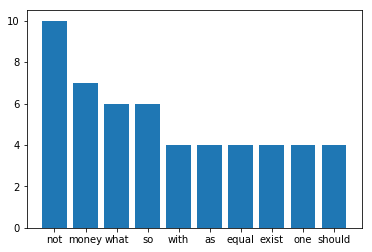

In [70]:
#module to visualize words frequencies
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
%matplotlib inline

my_stop_words = ["  ", " ", "the", "a", "an", "of", "to", 
                 "for", "in", "on", "that", "this", "and", 
                 "of", "at", "in", "between", "is", "are",
                "am", "i", "do", "does", "be", "if", "please", "s"
                "there", "any", "have", "but", "it", "my", "you", "or"]

def print_word_freq(list_of_strings, num_of_top_words):
    word_list = []
    for msg in list_of_strings:
        text_list = msg.split()
        for word in text_list:
            if word not in my_stop_words:
                word_list.append(word)

    counts = dict(Counter(word_list).most_common(num_of_top_words))
    plt.bar(list(counts.keys()), list(counts.values()))
    plt.show()

def word_freq_for_intent(intent_str, num_of_top_words):
    intent_id = label_to_id_dict[intent_str]
    msgs_to_visualize = []
    for index, msg in enumerate(X):
        if y[index] == intent_id:
            msgs_to_visualize.append(msg)
    print_word_freq(msgs_to_visualize, num_of_top_words)
    
word_freq_for_intent('frustration', 10)

In [22]:
#wrangles sentences and their intents into sparse vector representation and integer labels
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import spacy
import re
import random
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

nlp = spacy.load("en_core_web_sm")

def read_data_from_csv(file_name):
    X = []
    y = []
    with open(file_name + ".csv", "r") as f:
        reader = csv.reader(f)
        for line in reader:
            y.append(line[0])
            X.append(line[1])
    return X, np.array(y)

train_msgs, y_train = read_data_from_csv("train")
dev_msgs, y_dev = read_data_from_csv("dev")
ids, labels = read_data_from_csv("label_to_id")
label_to_id_dict = dict(zip(labels, ids))

my_stop_words = ["  ", " ", "the", "a", "an", "of", "to", 
                 "for", "in", "on", "that", "this", "and", 
                 "of", "at", "in", "between", "is", "are",
                "am", "i", "do", "does", "be", "if", "please", "s"
                "there", "any", "have"]

def Tokenize(text):
    return text.split(' ')

#class takes a list of sentences 
class SemanticHasher:
    
    def __init__(self, sentences):
        self.all_sub_tokens = {} #All trigrams in sentences are keys, value is trigram id
        self.num_of_sub_tokens = 0
        self.examples = [] #hashed sentences. Example: ["I pie", "no"] -> ['#I# #pi pie ie#', '#no no#']
        self.stop_words = my_stop_words
        self.subword_hash(sentences)
    
    #This function is private. Not to be used outside of class
    def subword_hash(self, sentences): 
        for raw_text in sentences:
            example = self.hash_sentence(raw_text, init_stage = 1)
            self.examples.append(example)
            
    #this function hashes the sentence after pre-processing it, to be used outside of class
    def hash_sentence(self, sentence, init_stage = 0):
        hashed_sentence = []
        tokens = nlp(sentence)
        for token in tokens:
            if token.text in self.stop_words:
                continue
            word = token.lemma_
            #if word in self.words_to_delete:
                #continue
            hashed_word = '#' + word + '#'
            for index in range(0, len(hashed_word) - 2):
                trigram = hashed_word[index : index + 3]
                hashed_sentence.append(trigram)
                #condition is false when function is called outside of class
                if init_stage and trigram not in self.all_sub_tokens:
                    self.all_sub_tokens[trigram] = self.num_of_sub_tokens  
                    self.num_of_sub_tokens += 1
        return ' '.join(hashed_sentence)

vec = CountVectorizer(tokenizer=Tokenize, lowercase=False)
#Creating train
my_hasher = SemanticHasher(train_msgs)
X_train = vec.fit_transform(my_hasher.examples)

#creating and hashing dev set
hashed_dev_msgs = [my_hasher.hash_sentence(msg) for msg in dev_msgs]
X_dev = vec.transform(hashed_dev_msgs)

#make sure number of samples matches number of labels
assert len(y_train) == X_train.shape[0]

#make sure number of features matches number of trigrams seen in train_data
assert my_hasher.num_of_sub_tokens == X_train.shape[1]
print("Wrangling done")

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_dev = clf.predict(X_dev)
report = classification_report(y_dev, y_pred_dev, target_names=label_to_id_dict.keys(), output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("classificationReport.csv")

Wrangling done
buttocks i cut my delivery ###Predicted intent: customer support @@@Real intent: generic question
show me again the cut for pant ###Predicted intent: customer support @@@Real intent: back
hiya i bought foundation through house of fraser do you know a way i can find out which one ###Predicted intent: product not found @@@Real intent: customer support
hi angela just wondered if you could advise if the repair wear laser focus day cream has been discontinued please ###Predicted intent: customer support @@@Real intent: product not found
i would like to discovery some new product to add to my skincare act ###Predicted intent: new facecare regimen @@@Real intent: shop new arrivals
ok thank you i also looked at the clinique smart custom moisturizer but is this for older skin do you ever do samples of the super defence ###Predicted intent: product aspect information @@@Real intent: product not found
where i can find your outlet located in philadelphia ###Predicted intent: product


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 50.156980991363525
Eval Metrics (Train): {'accuracy': 0.39559633, 'average_loss': 1.9810706, 'loss': 245.38261, 'global_step': 100}
Eval Metrics (Validation): {'accuracy': 0.400978, 'average_loss': 1.960188, 'loss': 229.06198, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 45.968873023986816
Eval Metrics (Train): {'accuracy': 0.6377982, 'average_loss': 1.401342, 'loss': 173.57532, 'global_step': 200}
Eval Metrics (Validation): {'accuracy': 0.6393643, 'average_loss': 1.4064761, 'loss': 164.35678, 'global_step': 200}

----------------------------------------------------------------------------------------------------
Training for step = 200
Train Time (s): 45.266331911087036
Eval Metrics (Train): {'accuracy': 0.7012844, 'average_loss': 1

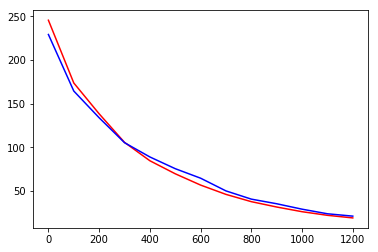

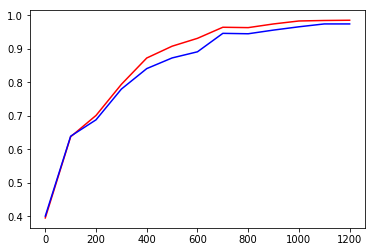

In [12]:
#Module that uses USE embeddings for intent classification
import tensorflow as tf
import tensorflow_hub as hub
import time
import warnings
import matplotlib.pyplot as plt
import os
%matplotlib inline
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

X_train = np.asarray(train_msgs+dev_msgs)
y_train = np.concatenate((y_train, y_dev))
X_dev = np.asarray(dev_msgs)
X_test = np.asarray(test_msgs)

embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=True)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_train}, y_train, 
    batch_size=10, num_epochs=None, shuffle=True)

predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_train}, y_train, shuffle=False)
    
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_dev}, y_dev, shuffle=False)

predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': X_test}, y_test, shuffle=False)

dnn = tf.estimator.DNNClassifier(
          hidden_units=[256],
          feature_columns=[embedding_feature],
          n_classes=len(label_to_id_dict)+1,
          activation_fn=tf.nn.relu,
          dropout=0.5,
          optimizer=tf.train.AdagradOptimizer(learning_rate=0.006))

TOTAL_STEPS = 1300
STEP_SIZE = 100
train_loss, dev_loss, train_acc, dev_acc, epochs = [], [], [], [], []
for step in range(0, TOTAL_STEPS, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    train_eval = dnn.evaluate(input_fn=predict_train_input_fn)
    dev_eval = dnn.evaluate(input_fn=predict_val_input_fn)
    print('Eval Metrics (Train):', train_eval)
    print('Eval Metrics (Validation):', dev_eval)
    train_loss.append(train_eval['loss'])
    dev_loss.append(dev_eval['loss'])
    train_acc.append(train_eval['accuracy'])
    dev_acc.append(dev_eval['accuracy'])
    epochs.append(step)
plt.plot(epochs, train_loss, 'r', epochs, dev_loss, 'b')
plt.show()
plt.plot(epochs, train_acc, 'r', epochs, dev_acc, 'b')
plt.show()

In [14]:
#classification report on test set
pred_test = list(dnn.predict(input_fn=predict_test_input_fn))
y_pred_test = []
for pred in pred_test:
    y_pred_test.append(pred['class_ids'][0])
print(classification_report(y_test, y_pred_test, target_names=label_to_id_dict.keys()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.67      0.67      0.67         3
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       0.94      1.00      0.97        31
           9       0.67      0.67      0.67         3
          10       1.00      0.93      0.96        14
          11       0.95      0.95      0.95        19
          12       1.00      1.00      1.00         6
          13       1.00      0.50      0.67         2
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00        13
          16       1.00      1.00      1.00        12
          17       0.89      0.89      0.89         9

   micro avg       0.96   

In [15]:
#print wrongly classified messages
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
for i, gold_label in enumerate(y_test):
    if gold_label != y_pred_test[i]:
        print(X_test[i] + " " + "###Predicted intent: " + id_to_label_dict[y_pred_test[i]] + " " + "@@@Real intent: " + id_to_label_dict[gold_label])

how can i track my delivery ###Predicted intent: order information @@@Real intent: generic question
ok but do you know if the jeans got sent out already because if it has i wo not bother ###Predicted intent: customer support @@@Real intent: help
hi i have not received my order yet i have talk to the national post company in denmark they tell me that the package is not arrived i dk yet and that i have to contact you there is a screen shot from the tracking information from usps hope you can he ###Predicted intent: customer support @@@Real intent: order information
do you guys sell anything like this please can i get some advice on this sit ###Predicted intent: generic question @@@Real intent: product not found
so am i and i like them but there is still missing a pair of jeans in the shipment pleas look at my message ###Predicted intent: help @@@Real intent: frustration
wish to see again ###Predicted intent: frustration @@@Real intent: back


In [16]:
#save trained model
feature_spec = tf.feature_column.make_parse_example_spec([embedding_feature])

# Build receiver function, and export.
serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
export_dir = dnn.export_savedmodel('export', serving_input_receiver_fn)
print("Done export")

Done export
